In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml


from pathlib import Path
from typing import Dict

In [12]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))

# yaml.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)

In [13]:
OUTPUT_DIR = f"{Path.cwd()}/benchmark_output"
MODEL_NAME = "01-ai/Yi-34B-200K"
MODEL_TP_DIMENSION = 2

SEQUENCE_LENGTHS = [2048, 4096, 8192, 16384]
CHUNK_SIZES = [512, 1024, 2048] + [max(SEQUENCE_LENGTHS)]

In [14]:
def generate_runs():
    devices = ",".join([str(x) for x in range(MODEL_TP_DIMENSION)])
    commands = []
    for sequence_length in SEQUENCE_LENGTHS:
        for chunk_size in CHUNK_SIZES:
            commands.append(
                f"CUDA_VISIBLE_DEVICES={devices} python sarathi/benchmark/main.py \\\n"
                f"--output_dir {OUTPUT_DIR} \\\n"
                f"--model_name {MODEL_NAME} \\\n"
                f"--model_max_model_len {max(SEQUENCE_LENGTHS)} \\\n"
                f"--cluster_num_replicas 1 \\\n"
                f"--model_tensor_parallel_degree {MODEL_TP_DIMENSION} \\\n"
                f"--model_pipeline_parallel_degree 1 \\\n"
                f"--request_generator_provider synthetic \\\n"
                f"--synthetic_request_generator_length_provider synthetic \\\n"
                f"--synthetic_request_generator_length_provider uniform \\\n"
                f"--synthetic_request_generator_interval_provider static \\\n"
                f"--synthetic_request_generator_num_requests 5 \\\n"
                f"--uniform_request_length_generator_max_tokens {sequence_length} \\\n"
                f"--uniform_request_length_generator_min_tokens {sequence_length} \\\n"
                f"--uniform_request_length_generator_prefill_to_decode_ratio {sequence_length - 1} \\\n"
                f"--metrics_store_keep_individual_batch_metrics true \\\n"
                f"--metrics_store_enable_op_level_metrics false \\\n"
                f"--replica_scheduler_provider sarathi \\\n"
                f"--replica_scheduler_max_batch_size 1 \\\n"
                f"--sarathi_scheduler_chunk_size {chunk_size} \\\n"
                f"--sarathi_scheduler_enable_rolling_prefills false \\\n"
                f"--sarathi_scheduler_enable_dynamic_chunking_schedule false\n"
            )
    with open(f"prefill_chunking_overhead_runs.sh", "w") as f:
        f.write("#!/bin/bash\n")
        f.write("set -x\n")
        for command in commands:
            f.write(command + "\n")

In [15]:
def _get_run_directories():
    rootdir = Path(OUTPUT_DIR)
    subdirectory_list = [
        directory for directory in rootdir.iterdir() if directory.is_dir()
    ]
    return subdirectory_list

In [16]:
def _process_run(
    benchmark_config: Dict[str, object],
    batch_metrics: pd.DataFrame,
):
    prefill_length = benchmark_config["uniform_request_length_generator_max_tokens"] - 1
    chunk_size = benchmark_config["sarathi_scheduler_chunk_size"]
    num_requests = benchmark_config["synthetic_request_generator_num_requests"]

    batch_metrics = batch_metrics[batch_metrics["batch_num_decode_tokens"] == 0]
    prefill_execution_time = batch_metrics["batch_execution_time"].sum() * 1000
    return {
        "prefill_length": prefill_length,
        "chunk_size": str(chunk_size),
        "prefill_execution_time": prefill_execution_time / num_requests,
    }

In [17]:
# Process runs to find throughput gain and decode speedup
def _process_runs():
    run_directories = _get_run_directories()
    run_directories.sort()
    num_runs = len(SEQUENCE_LENGTHS) * len(CHUNK_SIZES)
    run_directories = run_directories[-num_runs:]

    baseline = {}
    datapoints = []

    yaml.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
    for run_dir in run_directories:
        try:
            with open(
                f"{run_dir}/benchmark_config.yml", "r"
            ) as benchmark_config_file, open(
                f"{run_dir}/replica_0/batch_metrics.csv", "r"
            ) as batch_metrics_file:
                yaml.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
                benchmark_config = yaml.safe_load(benchmark_config_file)
                batch_metrics = pd.read_csv(batch_metrics_file)
                datapoint = _process_run(benchmark_config, batch_metrics)
                if int(datapoint["chunk_size"]) == max(SEQUENCE_LENGTHS):
                    baseline[datapoint["prefill_length"]] = datapoint.copy()
                datapoints.append(datapoint)
        except FileNotFoundError as e:
            print(f"Skipping {run_dir} due to {e}")
    for datapoint in datapoints:
        datapoint["prefill_execution_time_relative"] = (
            datapoint["prefill_execution_time"]
            / baseline[datapoint["prefill_length"]]["prefill_execution_time"]
        )
    return pd.DataFrame(datapoints)

In [18]:
def plot():
    df = _process_runs()
    df.to_csv("chunking-overhead.csv", index=False)

    sns.set_style("whitegrid")
    g = sns.FacetGrid(df, col='prefill_length', sharex=False, sharey=True)
    g.map(sns.barplot, "chunk_size", 'prefill_execution_time_relative')
    plt.show()

In [19]:
# generate_runs()

/home/amey/sarathi-lean/env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


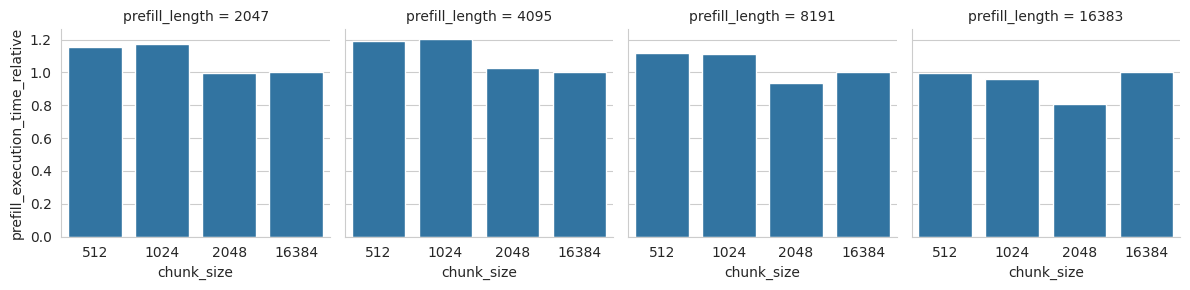

In [20]:
plot()